## Imports

In [1]:
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from keras import layers

## Data

In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [38]:
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [39]:
dataset.shape

(398, 8)

In [40]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [41]:
dataset = dataset.dropna()

In [43]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [44]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')

In [45]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [47]:
from sklearn.model_selection import train_test_split

In [48]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [52]:
train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']].corr()

,MPG,Cylinders,Displacement,Weight
MPG,1.000000,-0.780555,-0.811580,-0.835568
Cylinders,-0.780555,1.000000,0.952711,0.893325
Displacement,-0.811580,0.952711,1.000000,0.927345
Weight,-0.835568,0.893325,0.927345,1.000000


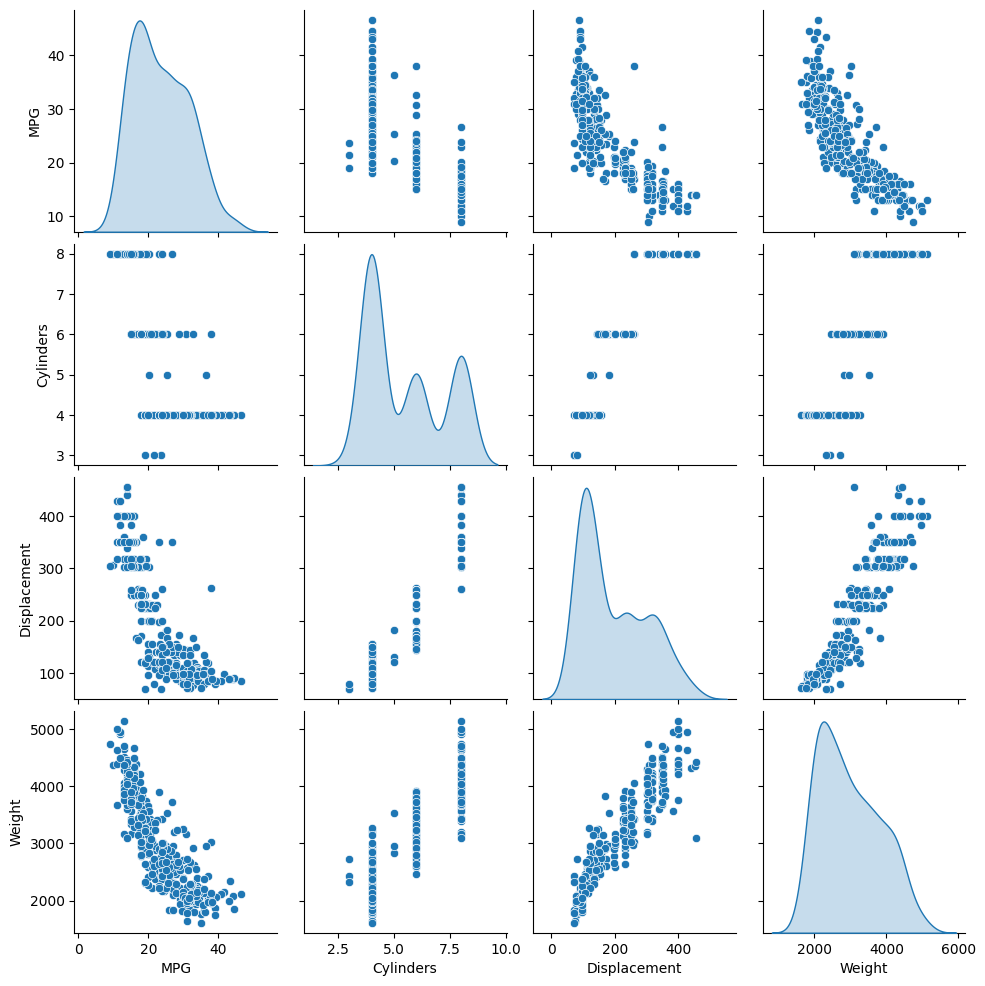

In [51]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [54]:
train_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.599361,7.956255,9.0,17.0,23.0,30.0,46.6
Cylinders,313.0,5.482428,1.700446,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,195.517572,103.766567,70.0,105.0,151.0,302.0,455.0
Horsepower,313.0,104.594249,38.283669,46.0,76.0,95.0,129.0,230.0
Weight,313.0,2986.124601,841.133957,1613.0,2234.0,2855.0,3645.0,5140.0
Acceleration,313.0,15.544089,2.817864,8.0,13.5,15.5,17.3,24.8
Model Year,313.0,76.207668,3.630136,70.0,73.0,76.0,79.0,82.0
Europe,313.0,0.153355,0.360906,0.0,0.0,0.0,0.0,1.0
Japan,313.0,0.201278,0.401597,0.0,0.0,0.0,0.0,1.0
USA,313.0,0.645367,0.479168,0.0,0.0,1.0,1.0,1.0


In [55]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Model

In [60]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [61]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                    optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [66]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_3 (Dense)             (None, 64)                640       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [67]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 51ms/step - loss: 23.1030 - val_loss: 24.5461
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 22.4972 - val_loss: 23.9459
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 21.8654 - val_loss: 23.2882
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 21.1431 - val_loss: 22.4735
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 20.2018 - val_loss: 21.3998
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 18.9381 - val_loss: 19.9613
Epoch 7/100
8/8 [==============================] - 0s 11ms/step - loss: 17.2659 - val_loss: 18.0463
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 15.1510 - val_loss: 15.7841
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 12.9159 - val_loss: 13.3098
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 10.7112 - val_loss: 10.5279


In [68]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

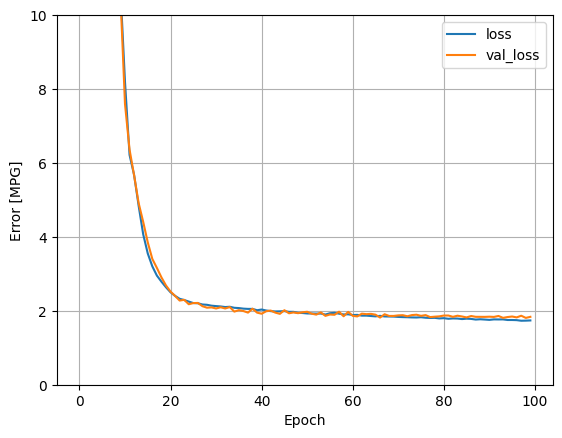

In [69]:
plot_loss(history)

In [70]:
pred_labels = dnn_model.evaluate(test_features, test_labels, verbose=0)

3/3 [==============================] - 0s 3ms/step


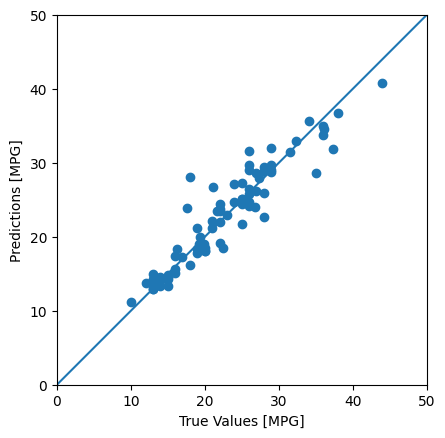

In [73]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

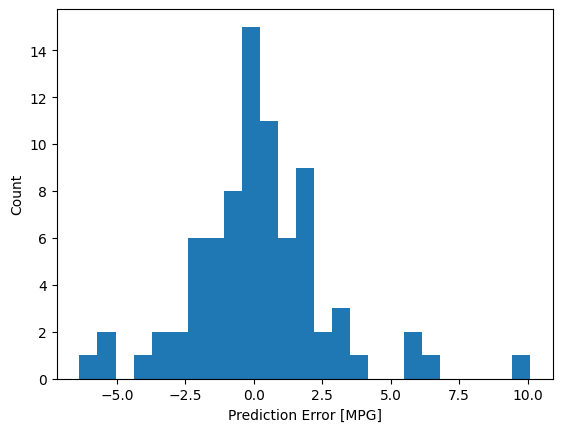

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')